In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb
import xgboost as xgb
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [3]:
train_df = pd.read_csv('density.csv')

In [4]:
state_employment = pd.read_csv('state_employment.csv')
state_employment = state_employment[['state','first_day_of_month','pct_non_inst_pop','pct_employed','pct_unemployed']]
state_employment

,state,first_day_of_month,pct_non_inst_pop,pct_employed,pct_unemployed
0,Alabama,2019-02-01,57.7,55.6,3.7
1,Alaska,2019-02-01,64.7,60.9,5.8
2,Arizona,2019-02-01,61.7,58.6,5.0
3,Arkansas,2019-02-01,58.6,56.5,3.6
4,California,2019-02-01,62.4,59.7,4.3
...,...,...,...,...,...
2392,Virginia,2022-12-01,63.6,61.7,2.8
2393,Washington,2022-12-01,64.4,61.8,4.0
2394,West Virginia,2022-12-01,54.9,52.7,4.1
2395,Wisconsin,2022-12-01,64.9,62.8,3.3


In [5]:
outer_merged = pd.merge(train_df, state_employment, how="outer", on=["state",'first_day_of_month'])
outer_merged = outer_merged.dropna()
#check
cols_with_missing = [col for col in outer_merged.columns if outer_merged[col].isnull().any()]
print('number of missing columns in train data is : ',len(cols_with_missing))
print(cols_with_missing)

number of missing columns in train data is :  0
[]


In [6]:
ten_yr_treasury_rate = pd.read_csv('10yr_treasury_rate.csv')
ten_yr_treasury_rate

,first_day_of_month,DGS10_last
0,2018-02-01,2.72
1,2018-03-01,2.87
2,2018-04-01,2.74
3,2018-05-01,2.95
4,2018-06-01,2.83
...,...,...
56,2022-10-01,3.83
57,2022-11-01,4.10
58,2022-12-01,3.68
59,2023-01-01,3.88


In [7]:
outer_merged = pd.merge(outer_merged, ten_yr_treasury_rate, how="outer", on=['first_day_of_month'])
outer_merged = outer_merged.dropna()
#check
cols_with_missing = [col for col in outer_merged.columns if outer_merged[col].isnull().any()]
print('number of missing columns in train data is : ',len(cols_with_missing))
print(cols_with_missing)

number of missing columns in train data is :  0
[]


In [8]:
lbl_state = preprocessing.LabelEncoder()
lbl_state.fit(outer_merged['state'])
outer_merged['state']=lbl_state.transform(outer_merged['state'])
outer_merged

,Unnamed: 0,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,year_month,bb,cl,fb,iw,hh,pct_non_inst_pop,pct_employed,pct_unemployed,DGS10_last
0,0.0,1001_2019-08-01,1001.0,82.0,0,2019-08-01,3.007682,1249.0,2019.0,8.0,201908.0,76.6,14.5,2.1,1.3,55317.0,57.7,56.0,2.9,2.02
1,39.0,1003_2019-08-01,1003.0,89.0,0,2019-08-01,7.239156,11464.0,2019.0,8.0,201908.0,74.5,20.4,3.2,1.4,52562.0,57.7,56.0,2.9,2.02
2,78.0,1005_2019-08-01,1005.0,100.0,0,2019-08-01,1.073138,222.0,2019.0,8.0,201908.0,57.2,7.6,2.7,0.5,33368.0,57.7,56.0,2.9,2.02
3,117.0,1007_2019-08-01,1007.0,149.0,0,2019-08-01,1.310777,234.0,2019.0,8.0,201908.0,62.0,8.1,1.0,1.2,43404.0,57.7,56.0,2.9,2.02
4,156.0,1009_2019-08-01,1009.0,164.0,0,2019-08-01,1.544148,681.0,2019.0,8.0,201908.0,65.8,8.7,4.5,1.3,47412.0,57.7,56.0,2.9,2.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,122108.0,56037_2022-10-01,56037.0,1630.0,50,2022-10-01,2.823801,905.0,2022.0,10.0,202210.0,86.7,13.7,5.2,0.9,73384.0,63.1,61.0,3.3,3.83
122261,122147.0,56039_2022-10-01,56039.0,1655.0,50,2022-10-01,26.273220,5035.0,2022.0,10.0,202210.0,89.1,37.2,11.4,1.5,87053.0,63.1,61.0,3.3,3.83
122262,122186.0,56041_2022-10-01,56041.0,1708.0,50,2022-10-01,4.009369,582.0,2022.0,10.0,202210.0,91.4,12.6,2.9,1.7,72458.0,63.1,61.0,3.3,3.83
122263,122225.0,56043_2022-10-01,56043.0,1767.0,50,2022-10-01,3.126551,189.0,2022.0,10.0,202210.0,82.8,15.0,2.2,0.9,57306.0,63.1,61.0,3.3,3.83


In [9]:
location = pd.read_csv('cfips_location.csv')
location

,cfips,name,lng,lat
0,1059,Franklin,-87.843283,34.442381
1,13111,Fannin,-84.319296,34.864126
2,19109,Kossuth,-94.206898,43.204140
3,40115,Ottawa,-94.810589,36.835878
4,42115,Susquehanna,-75.800905,41.821277
...,...,...,...,...
3228,12029,Dixie,-83.158705,29.608068
3229,18017,Cass,-86.346207,40.761660
3230,26091,Lenawee,-84.066412,41.894694
3231,72003,Aguada,-67.175247,18.360392


In [10]:
outer_merged = pd.merge(outer_merged, location, how="outer", on=["cfips"])
outer_merged = outer_merged.dropna()
#check
cols_with_missing = [col for col in outer_merged.columns if outer_merged[col].isnull().any()]
print('number of missing columns in train data is : ',len(cols_with_missing))
print(cols_with_missing)
cols_with_missing = [col for col in outer_merged.columns if outer_merged[col].isnull().any()]
print('number of missing columns in test data is : ',len(cols_with_missing))
print(cols_with_missing)

outer_merged

number of missing columns in train data is :  0
[]
number of missing columns in test data is :  0
[]


,Unnamed: 0,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,...,fb,iw,hh,pct_non_inst_pop,pct_employed,pct_unemployed,DGS10_last,name,lng,lat
0,0.0,1001_2019-08-01,1001.0,82.0,0.0,2019-08-01,3.007682,1249.0,2019.0,8.0,...,2.1,1.3,55317.0,57.7,56.0,2.9,2.02,Autauga,-86.642900,32.535142
1,1.0,1001_2019-09-01,1001.0,82.0,0.0,2019-09-01,2.884870,1198.0,2019.0,9.0,...,2.1,1.3,55317.0,57.7,56.0,2.9,1.50,Autauga,-86.642900,32.535142
2,2.0,1001_2019-10-01,1001.0,82.0,0.0,2019-10-01,3.055843,1269.0,2019.0,10.0,...,2.1,1.3,55317.0,57.7,56.0,2.9,1.68,Autauga,-86.642900,32.535142
3,3.0,1001_2019-11-01,1001.0,82.0,0.0,2019-11-01,2.993233,1243.0,2019.0,11.0,...,2.1,1.3,55317.0,57.7,56.0,3.0,1.69,Autauga,-86.642900,32.535142
4,4.0,1001_2019-12-01,1001.0,82.0,0.0,2019-12-01,2.993233,1243.0,2019.0,12.0,...,2.1,1.3,55317.0,57.7,55.9,3.1,1.78,Autauga,-86.642900,32.535142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,122260.0,56045_2022-06-01,56045.0,1793.0,50.0,2022-06-01,1.803249,101.0,2022.0,6.0,...,2.3,0.0,53333.0,63.7,61.6,3.2,2.85,Weston,-104.567404,43.840315
122261,122261.0,56045_2022-07-01,56045.0,1793.0,50.0,2022-07-01,1.803249,101.0,2022.0,7.0,...,2.3,0.0,53333.0,63.5,61.6,3.1,2.98,Weston,-104.567404,43.840315
122262,122262.0,56045_2022-08-01,56045.0,1793.0,50.0,2022-08-01,1.785395,100.0,2022.0,8.0,...,2.3,0.0,53333.0,63.4,61.5,3.0,2.67,Weston,-104.567404,43.840315
122263,122263.0,56045_2022-09-01,56045.0,1793.0,50.0,2022-09-01,1.785395,100.0,2022.0,9.0,...,2.3,0.0,53333.0,63.2,61.2,3.1,3.15,Weston,-104.567404,43.840315


In [11]:
train_df_1 = train_df[['row_id','cfips',	'county','state','first_day_of_month','microbusiness_density','active','year','month','year_month','bb',	'cl',	'fb',	'iw',	'hh']].copy()


In [12]:
df = pd.read_csv('county-neighbours.csv')
df
county_grouped = df.groupby(['County', 'Countycode']).size()
county_grouped

county_df = county_grouped.to_frame().reset_index().rename(columns={0: 'Number of Neighbouring Counties'})
county_df = county_df[['County', 'Countycode', 'Number of Neighbouring Counties']]
county_df['cfips']=county_df['Countycode']
county_df['nonc']=county_df['Number of Neighbouring Counties']
county_df = county_df[['cfips', 'nonc']]
county_df

,cfips,nonc
0,45001,6
1,22001,5
2,51001,7
3,16001,5
4,19001,7
...,...,...
3219,4027,4
3220,8125,7
3221,48505,3
3222,48507,6


In [13]:
df

,County,Countycode,Neighbour county,Neighbour county code
0,"Autauga County, AL",1001,"Chilton County, AL",1021
1,"Autauga County, AL",1001,"Dallas County, AL",1047
2,"Autauga County, AL",1001,"Elmore County, AL",1051
3,"Autauga County, AL",1001,"Lowndes County, AL",1085
4,"Autauga County, AL",1001,"Montgomery County, AL",1101
...,...,...,...,...
18961,"Yauco Municipio, PR",72153,"Lares Municipio, PR",72081
18962,"Yauco Municipio, PR",72153,"Maricao Municipio, PR",72093
18963,"Yauco Municipio, PR",72153,"Sabana Grande Municipio, PR",72121
18964,"St. John Island, VI",78020,"St. Thomas Island, VI",78030


In [14]:
outer_merged = pd.merge(outer_merged, county_df, how="outer", on=["cfips"])
outer_merged = outer_merged.dropna()
#check
cols_with_missing = [col for col in outer_merged.columns if outer_merged[col].isnull().any()]
print('number of missing columns in train data is : ',len(cols_with_missing))
print(cols_with_missing)
cols_with_missing = [col for col in outer_merged.columns if outer_merged[col].isnull().any()]
print('number of missing columns in test data is : ',len(cols_with_missing))
print(cols_with_missing)

outer_merged

number of missing columns in train data is :  0
[]
number of missing columns in test data is :  0
[]


,Unnamed: 0,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,...,iw,hh,pct_non_inst_pop,pct_employed,pct_unemployed,DGS10_last,name,lng,lat,nonc
0,0.0,1001_2019-08-01,1001.0,82.0,0.0,2019-08-01,3.007682,1249.0,2019.0,8.0,...,1.3,55317.0,57.7,56.0,2.9,2.02,Autauga,-86.642900,32.535142,5.0
1,1.0,1001_2019-09-01,1001.0,82.0,0.0,2019-09-01,2.884870,1198.0,2019.0,9.0,...,1.3,55317.0,57.7,56.0,2.9,1.50,Autauga,-86.642900,32.535142,5.0
2,2.0,1001_2019-10-01,1001.0,82.0,0.0,2019-10-01,3.055843,1269.0,2019.0,10.0,...,1.3,55317.0,57.7,56.0,2.9,1.68,Autauga,-86.642900,32.535142,5.0
3,3.0,1001_2019-11-01,1001.0,82.0,0.0,2019-11-01,2.993233,1243.0,2019.0,11.0,...,1.3,55317.0,57.7,56.0,3.0,1.69,Autauga,-86.642900,32.535142,5.0
4,4.0,1001_2019-12-01,1001.0,82.0,0.0,2019-12-01,2.993233,1243.0,2019.0,12.0,...,1.3,55317.0,57.7,55.9,3.1,1.78,Autauga,-86.642900,32.535142,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,122260.0,56045_2022-06-01,56045.0,1793.0,50.0,2022-06-01,1.803249,101.0,2022.0,6.0,...,0.0,53333.0,63.7,61.6,3.2,2.85,Weston,-104.567404,43.840315,7.0
122261,122261.0,56045_2022-07-01,56045.0,1793.0,50.0,2022-07-01,1.803249,101.0,2022.0,7.0,...,0.0,53333.0,63.5,61.6,3.1,2.98,Weston,-104.567404,43.840315,7.0
122262,122262.0,56045_2022-08-01,56045.0,1793.0,50.0,2022-08-01,1.785395,100.0,2022.0,8.0,...,0.0,53333.0,63.4,61.5,3.0,2.67,Weston,-104.567404,43.840315,7.0
122263,122263.0,56045_2022-09-01,56045.0,1793.0,50.0,2022-09-01,1.785395,100.0,2022.0,9.0,...,0.0,53333.0,63.2,61.2,3.1,3.15,Weston,-104.567404,43.840315,7.0


In [15]:
df['Other State'] = df.apply(lambda x: 1 if x['County'][-2:] != x['Neighbour county'][-2:] else 0, axis=1)
state_grouped = df.groupby(['County', 'Countycode'])['Other State'].sum()
state_df = state_grouped.to_frame().reset_index().rename(columns={'Other State': 'Neighbour in Other State'})
state_df = state_df[['County', 'Countycode', 'Neighbour in Other State']]
state_df['Neighbour in Other State'] = state_df['Neighbour in Other State'].apply(lambda x: 1 if x != 0 else x)
state_df['cfips']=state_df['Countycode']
state_df['nios']=state_df['Neighbour in Other State']

In [16]:
state_df = state_df[['cfips','nios']]
state_df

,cfips,nios
0,45001,1
1,22001,0
2,51001,1
3,16001,0
4,19001,0
...,...,...
3219,4027,1
3220,8125,1
3221,48505,0
3222,48507,0


In [17]:
outer_merged = pd.merge(outer_merged, state_df, how="outer", on=["cfips"])
outer_merged = outer_merged.dropna()
#check
cols_with_missing = [col for col in outer_merged.columns if outer_merged[col].isnull().any()]
print('number of missing columns in train data is : ',len(cols_with_missing))
print(cols_with_missing)
cols_with_missing = [col for col in outer_merged.columns if outer_merged[col].isnull().any()]
print('number of missing columns in test data is : ',len(cols_with_missing))
print(cols_with_missing)

outer_merged

number of missing columns in train data is :  0
[]
number of missing columns in test data is :  0
[]


,Unnamed: 0,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,...,hh,pct_non_inst_pop,pct_employed,pct_unemployed,DGS10_last,name,lng,lat,nonc,nios
0,0.0,1001_2019-08-01,1001.0,82.0,0.0,2019-08-01,3.007682,1249.0,2019.0,8.0,...,55317.0,57.7,56.0,2.9,2.02,Autauga,-86.642900,32.535142,5.0,0
1,1.0,1001_2019-09-01,1001.0,82.0,0.0,2019-09-01,2.884870,1198.0,2019.0,9.0,...,55317.0,57.7,56.0,2.9,1.50,Autauga,-86.642900,32.535142,5.0,0
2,2.0,1001_2019-10-01,1001.0,82.0,0.0,2019-10-01,3.055843,1269.0,2019.0,10.0,...,55317.0,57.7,56.0,2.9,1.68,Autauga,-86.642900,32.535142,5.0,0
3,3.0,1001_2019-11-01,1001.0,82.0,0.0,2019-11-01,2.993233,1243.0,2019.0,11.0,...,55317.0,57.7,56.0,3.0,1.69,Autauga,-86.642900,32.535142,5.0,0
4,4.0,1001_2019-12-01,1001.0,82.0,0.0,2019-12-01,2.993233,1243.0,2019.0,12.0,...,55317.0,57.7,55.9,3.1,1.78,Autauga,-86.642900,32.535142,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122143,122260.0,56045_2022-06-01,56045.0,1793.0,50.0,2022-06-01,1.803249,101.0,2022.0,6.0,...,53333.0,63.7,61.6,3.2,2.85,Weston,-104.567404,43.840315,7.0,1
122144,122261.0,56045_2022-07-01,56045.0,1793.0,50.0,2022-07-01,1.803249,101.0,2022.0,7.0,...,53333.0,63.5,61.6,3.1,2.98,Weston,-104.567404,43.840315,7.0,1
122145,122262.0,56045_2022-08-01,56045.0,1793.0,50.0,2022-08-01,1.785395,100.0,2022.0,8.0,...,53333.0,63.4,61.5,3.0,2.67,Weston,-104.567404,43.840315,7.0,1
122146,122263.0,56045_2022-09-01,56045.0,1793.0,50.0,2022-09-01,1.785395,100.0,2022.0,9.0,...,53333.0,63.2,61.2,3.1,3.15,Weston,-104.567404,43.840315,7.0,1


In [18]:
outer_merged.drop(columns=['row_id','name','active','county','year_month']).to_csv("microbusiness_data.csv") #'nonc','nios'

In [19]:
coast = pd.read_csv("county_coastline.csv")
outer_merged = pd.merge(outer_merged, coast, how="inner", on=["cfips"])


In [20]:
outer_merged = outer_merged.dropna()
outer_merged

,Unnamed: 0,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,...,pct_non_inst_pop,pct_employed,pct_unemployed,DGS10_last,name,lng,lat,nonc,nios,is_coastal
0,0.0,1001_2019-08-01,1001.0,82.0,0.0,2019-08-01,3.007682,1249.0,2019.0,8.0,...,57.7,56.0,2.9,2.02,Autauga,-86.642900,32.535142,5.0,0,False
1,1.0,1001_2019-09-01,1001.0,82.0,0.0,2019-09-01,2.884870,1198.0,2019.0,9.0,...,57.7,56.0,2.9,1.50,Autauga,-86.642900,32.535142,5.0,0,False
2,2.0,1001_2019-10-01,1001.0,82.0,0.0,2019-10-01,3.055843,1269.0,2019.0,10.0,...,57.7,56.0,2.9,1.68,Autauga,-86.642900,32.535142,5.0,0,False
3,3.0,1001_2019-11-01,1001.0,82.0,0.0,2019-11-01,2.993233,1243.0,2019.0,11.0,...,57.7,56.0,3.0,1.69,Autauga,-86.642900,32.535142,5.0,0,False
4,4.0,1001_2019-12-01,1001.0,82.0,0.0,2019-12-01,2.993233,1243.0,2019.0,12.0,...,57.7,55.9,3.1,1.78,Autauga,-86.642900,32.535142,5.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122143,122260.0,56045_2022-06-01,56045.0,1793.0,50.0,2022-06-01,1.803249,101.0,2022.0,6.0,...,63.7,61.6,3.2,2.85,Weston,-104.567404,43.840315,7.0,1,False
122144,122261.0,56045_2022-07-01,56045.0,1793.0,50.0,2022-07-01,1.803249,101.0,2022.0,7.0,...,63.5,61.6,3.1,2.98,Weston,-104.567404,43.840315,7.0,1,False
122145,122262.0,56045_2022-08-01,56045.0,1793.0,50.0,2022-08-01,1.785395,100.0,2022.0,8.0,...,63.4,61.5,3.0,2.67,Weston,-104.567404,43.840315,7.0,1,False
122146,122263.0,56045_2022-09-01,56045.0,1793.0,50.0,2022-09-01,1.785395,100.0,2022.0,9.0,...,63.2,61.2,3.1,3.15,Weston,-104.567404,43.840315,7.0,1,False


In [21]:
outer_merged.drop(columns=['row_id','name','active','county','year_month']).to_csv("microbusiness_data.csv") #'nonc','nios'
outer_merged = outer_merged.dropna()
outer_merged

,Unnamed: 0,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,...,pct_non_inst_pop,pct_employed,pct_unemployed,DGS10_last,name,lng,lat,nonc,nios,is_coastal
0,0.0,1001_2019-08-01,1001.0,82.0,0.0,2019-08-01,3.007682,1249.0,2019.0,8.0,...,57.7,56.0,2.9,2.02,Autauga,-86.642900,32.535142,5.0,0,False
1,1.0,1001_2019-09-01,1001.0,82.0,0.0,2019-09-01,2.884870,1198.0,2019.0,9.0,...,57.7,56.0,2.9,1.50,Autauga,-86.642900,32.535142,5.0,0,False
2,2.0,1001_2019-10-01,1001.0,82.0,0.0,2019-10-01,3.055843,1269.0,2019.0,10.0,...,57.7,56.0,2.9,1.68,Autauga,-86.642900,32.535142,5.0,0,False
3,3.0,1001_2019-11-01,1001.0,82.0,0.0,2019-11-01,2.993233,1243.0,2019.0,11.0,...,57.7,56.0,3.0,1.69,Autauga,-86.642900,32.535142,5.0,0,False
4,4.0,1001_2019-12-01,1001.0,82.0,0.0,2019-12-01,2.993233,1243.0,2019.0,12.0,...,57.7,55.9,3.1,1.78,Autauga,-86.642900,32.535142,5.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122143,122260.0,56045_2022-06-01,56045.0,1793.0,50.0,2022-06-01,1.803249,101.0,2022.0,6.0,...,63.7,61.6,3.2,2.85,Weston,-104.567404,43.840315,7.0,1,False
122144,122261.0,56045_2022-07-01,56045.0,1793.0,50.0,2022-07-01,1.803249,101.0,2022.0,7.0,...,63.5,61.6,3.1,2.98,Weston,-104.567404,43.840315,7.0,1,False
122145,122262.0,56045_2022-08-01,56045.0,1793.0,50.0,2022-08-01,1.785395,100.0,2022.0,8.0,...,63.4,61.5,3.0,2.67,Weston,-104.567404,43.840315,7.0,1,False
122146,122263.0,56045_2022-09-01,56045.0,1793.0,50.0,2022-09-01,1.785395,100.0,2022.0,9.0,...,63.2,61.2,3.1,3.15,Weston,-104.567404,43.840315,7.0,1,False


In [22]:
df = pd.read_csv("microbusiness_data.csv", parse_dates=["first_day_of_month"],index_col=[0])

In [23]:
#df = pd.DataFrame()
df['microbusiness_density_6_months_later'] = df['microbusiness_density']
df['first_day_of_month_6_months_later'] = df['first_day_of_month'] + pd.DateOffset(months=6)
df = df.merge(df[['cfips', 'microbusiness_density', 'first_day_of_month']], left_on=['cfips', 'first_day_of_month_6_months_later'], right_on=['cfips', 'first_day_of_month'])
df = df.drop(['first_day_of_month_6_months_later'], axis=1)


In [24]:
df = df.drop(columns=['microbusiness_density_6_months_later','first_day_of_month_y'])
df

,Unnamed: 0.1,cfips,state,first_day_of_month_x,microbusiness_density_x,year,month,bb,cl,fb,...,pct_non_inst_pop,pct_employed,pct_unemployed,DGS10_last,lng,lat,nonc,nios,is_coastal,microbusiness_density_y
0,0.0,1001.0,0.0,2019-08-01,3.007682,2019.0,8.0,76.6,14.5,2.1,...,57.7,56.0,2.9,2.02,-86.642900,32.535142,5.0,0,False,2.909326
1,1.0,1001.0,0.0,2019-09-01,2.884870,2019.0,9.0,76.6,14.5,2.1,...,57.7,56.0,2.9,1.50,-86.642900,32.535142,5.0,0,False,2.933231
2,2.0,1001.0,0.0,2019-10-01,3.055843,2019.0,10.0,76.6,14.5,2.1,...,57.7,56.0,2.9,1.68,-86.642900,32.535142,5.0,0,False,3.000167
3,3.0,1001.0,0.0,2019-11-01,2.993233,2019.0,11.0,76.6,14.5,2.1,...,57.7,56.0,3.0,1.69,-86.642900,32.535142,5.0,0,False,3.004948
4,4.0,1001.0,0.0,2019-12-01,2.993233,2019.0,12.0,76.6,14.5,2.1,...,57.7,55.9,3.1,1.78,-86.642900,32.535142,5.0,0,False,3.019292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103351,122254.0,56045.0,50.0,2021-12-01,1.796300,2021.0,12.0,76.8,13.4,1.7,...,63.7,61.2,4.0,1.43,-104.567404,43.840315,7.0,1,False,1.803249
103352,122255.0,56045.0,50.0,2022-01-01,1.749688,2022.0,1.0,79.7,12.7,2.3,...,63.6,61.1,4.0,1.52,-104.567404,43.840315,7.0,1,False,1.803249
103353,122256.0,56045.0,50.0,2022-02-01,1.749688,2022.0,2.0,79.7,12.7,2.3,...,63.7,61.3,3.8,1.79,-104.567404,43.840315,7.0,1,False,1.785395
103354,122257.0,56045.0,50.0,2022-03-01,1.767542,2022.0,3.0,79.7,12.7,2.3,...,63.7,61.3,3.6,1.83,-104.567404,43.840315,7.0,1,False,1.785395


In [25]:
df = df.rename(columns={'first_day_of_month_x': 'first_day_of_month'})
df = df.rename(columns={'microbusiness_density_x': 'previous_microbusiness_density'})
df = df.rename(columns={'microbusiness_density_y': 'microbusiness_density'})
df

,Unnamed: 0.1,cfips,state,first_day_of_month,previous_microbusiness_density,year,month,bb,cl,fb,...,pct_non_inst_pop,pct_employed,pct_unemployed,DGS10_last,lng,lat,nonc,nios,is_coastal,microbusiness_density
0,0.0,1001.0,0.0,2019-08-01,3.007682,2019.0,8.0,76.6,14.5,2.1,...,57.7,56.0,2.9,2.02,-86.642900,32.535142,5.0,0,False,2.909326
1,1.0,1001.0,0.0,2019-09-01,2.884870,2019.0,9.0,76.6,14.5,2.1,...,57.7,56.0,2.9,1.50,-86.642900,32.535142,5.0,0,False,2.933231
2,2.0,1001.0,0.0,2019-10-01,3.055843,2019.0,10.0,76.6,14.5,2.1,...,57.7,56.0,2.9,1.68,-86.642900,32.535142,5.0,0,False,3.000167
3,3.0,1001.0,0.0,2019-11-01,2.993233,2019.0,11.0,76.6,14.5,2.1,...,57.7,56.0,3.0,1.69,-86.642900,32.535142,5.0,0,False,3.004948
4,4.0,1001.0,0.0,2019-12-01,2.993233,2019.0,12.0,76.6,14.5,2.1,...,57.7,55.9,3.1,1.78,-86.642900,32.535142,5.0,0,False,3.019292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103351,122254.0,56045.0,50.0,2021-12-01,1.796300,2021.0,12.0,76.8,13.4,1.7,...,63.7,61.2,4.0,1.43,-104.567404,43.840315,7.0,1,False,1.803249
103352,122255.0,56045.0,50.0,2022-01-01,1.749688,2022.0,1.0,79.7,12.7,2.3,...,63.6,61.1,4.0,1.52,-104.567404,43.840315,7.0,1,False,1.803249
103353,122256.0,56045.0,50.0,2022-02-01,1.749688,2022.0,2.0,79.7,12.7,2.3,...,63.7,61.3,3.8,1.79,-104.567404,43.840315,7.0,1,False,1.785395
103354,122257.0,56045.0,50.0,2022-03-01,1.767542,2022.0,3.0,79.7,12.7,2.3,...,63.7,61.3,3.6,1.83,-104.567404,43.840315,7.0,1,False,1.785395


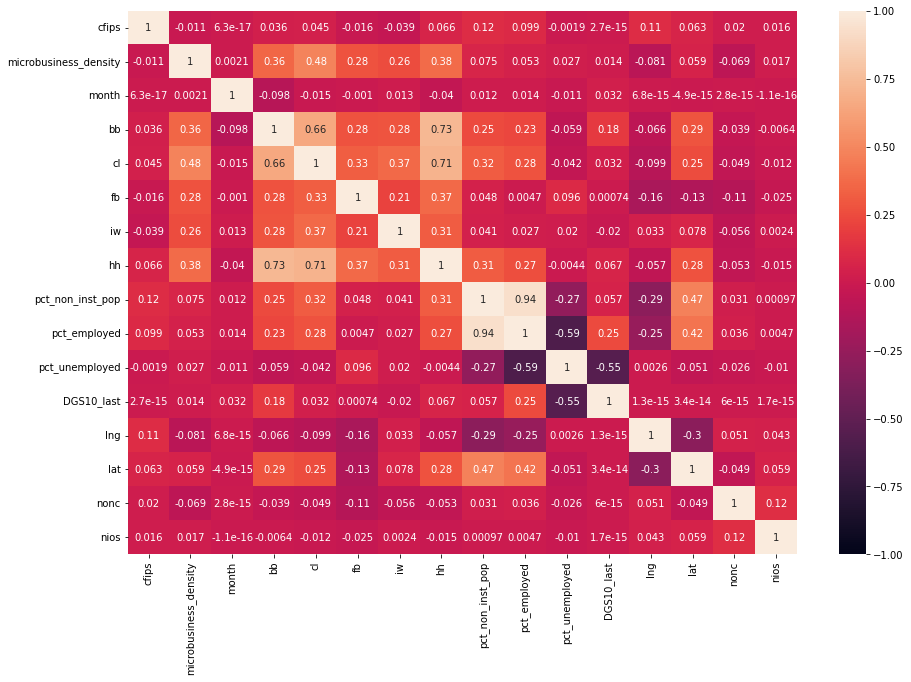

In [35]:
outer_merged.drop(columns=['row_id','name','active','county','state','year_month'])
# Compute the correlation matrix
corr_matrix = outer_merged.drop(columns=['row_id','name','active','county','state','year_month']).corr()

corr_matrix = df.corr()
# Print the correlation matrix
#print(corr_matrix)
# Create a heatmap of the correlations with a color range from -1 to 1 and display the values in the cells
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True)


In [34]:
df=df.drop(columns=['is_coastal','year','state','Unnamed: 0.1'])

In [ ]:
df.to_csv('microbusiness_data.csv')

In [36]:
###Zadaniem tego modelu jest przewidzenie przyszłego zagęszczenia mikroprzesiębiorstw w poszczególnych hrabstwach Stanów Zjednoczonych
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("microbusiness_data.csv", parse_dates=["first_day_of_month"],index_col=[0]) 

df = df.sort_values("first_day_of_month")

split_index = int(len(df) * 0.8)  
df_train = df[:split_index]
df_test = df[split_index:]

X_train = df_train.drop("microbusiness_density", axis=1)
y_train = df_train["microbusiness_density"]
X_test = df_test.drop("microbusiness_density", axis=1)
y_test = df_test["microbusiness_density"]

X_train["first_day_of_month"] = pd.to_datetime(X_train["first_day_of_month"])
X_test["first_day_of_month"] = pd.to_datetime(X_test["first_day_of_month"])

X_train["first_day_of_month"] = X_train["first_day_of_month"].apply(lambda x: x.timestamp())
X_test["first_day_of_month"] = X_test["first_day_of_month"].apply(lambda x: x.timestamp())

learning_rate = 0.05
n_estimators = 150
max_depth = 15
gamma = 0.1
subsample = 0.8
colsample_bytree = 0.8
reg_alpha = 1
reg_lambda = 1
silent = False

model = xgb.XGBRegressor(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        gamma = gamma,
                                        subsample = subsample,
                                        colsample_bytree = colsample_bytree,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                        silent = silent)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean squared error: {mse:.2f}")
print(f"R2 score: {r2:.2f}")

[22:46:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error: 4.93
R2 score: 0.85


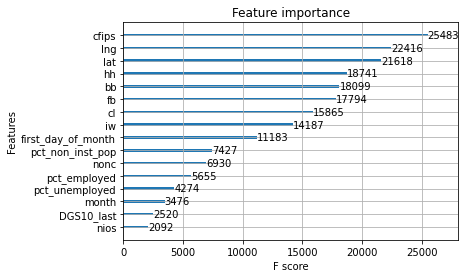

In [37]:
xgb.plot_importance(model)

In [38]:
###TO JEST TO
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("microbusiness_data.csv", parse_dates=["first_day_of_month"],index_col=[0]) 

df = df.sort_values("first_day_of_month")

split_index = int(len(df) * 0.8) 
df_train = df[:split_index]
df_test = df[split_index:]

X_train = df_train.drop("microbusiness_density", axis=1)
y_train = df_train["microbusiness_density"]
X_test = df_test.drop("microbusiness_density", axis=1)
y_test = df_test["microbusiness_density"]

X_train["first_day_of_month"] = pd.to_datetime(X_train["first_day_of_month"])
X_test["first_day_of_month"] = pd.to_datetime(X_test["first_day_of_month"])

X_train["first_day_of_month"] = X_train["first_day_of_month"].apply(lambda x: x.timestamp())
X_test["first_day_of_month"] = X_test["first_day_of_month"].apply(lambda x: x.timestamp())

learning_rate = 0.05
n_estimators = 100
max_depth = 30

model = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean squared error: {mse:.2f}")
print(f"R2 score: {r2:.2f}")

Mean squared error: 7.29
R2 score: 0.78
